In [1]:
import utils
import keras
import model01
import datasets
import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
# FILENAME = './output/MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5-200-0.6926.hdf5'
FILENAME = './output/MLPModel01_20170310_0845_LA1_F99_C2_L100_100_100_DO0.5-200-0.6890.hdf5'

In [3]:
#model = model01.MLPModel01.load(FILENAME)
# infers model description file from this filename
# loads model training history + weights from this specific file

In [4]:
model = keras.models.load_model(FILENAME)

In [5]:
#pc = model01.ProgressCallback.load('MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5')
pc = model01.ProgressCallback.load('MLPModel01_20170310_0845_LA1_F99_C2_L100_100_100_DO0.5')


loading from file: ./output/MLPModel01_20170310_0845_LA1_F99_C2_L100_100_100_DO0.5.npz


In [6]:
#plt.plot(pc.validation_losses)

In [25]:
# load test dataset
lookahead=1
dataset = 'DS2'
window=25
sym='USDJPY'
year=2014
X_test, Y_test, prices_test, fut_return_test = datasets.load(datasets.filename(dataset, lookahead, window, sym, year))

test: f1-score: 0.526, mean future return: 0.018 bps


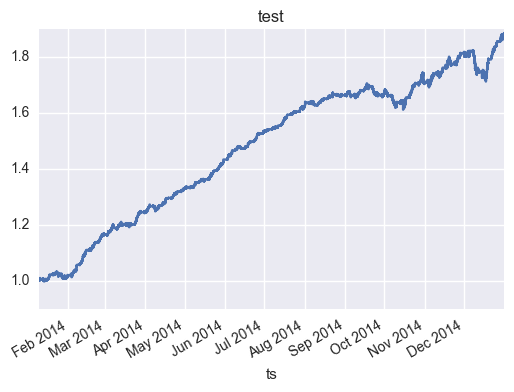

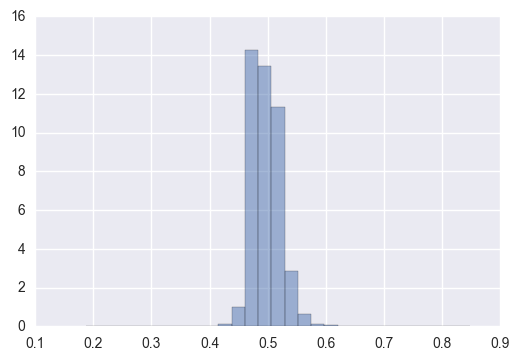

[[108897  73804]
 [ 95163  80395]]


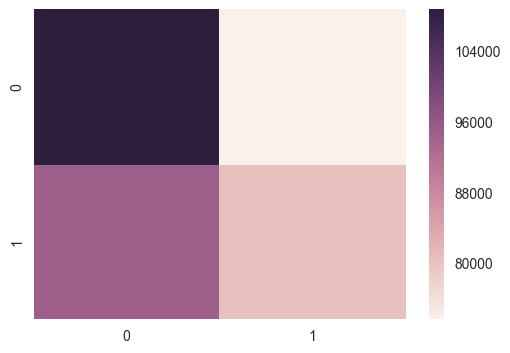

In [26]:
Y_test_pred = model.predict(X_test.as_matrix(), batch_size=1024)
metrics.performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred, cum_return_plot=True, histogram=True, heatmap=True)

-----------------------------------------


In [9]:
!! Idea: assess performance of 1 minute prediction over next n periods, e.g. by average signal, ewma signal.
    Versus predicting on n periods ahead directly.
    
    Increase N to point of being potentially tradeable.
    
    

IndentationError: unexpected indent (<ipython-input-9-a53d670d1814>, line 2)

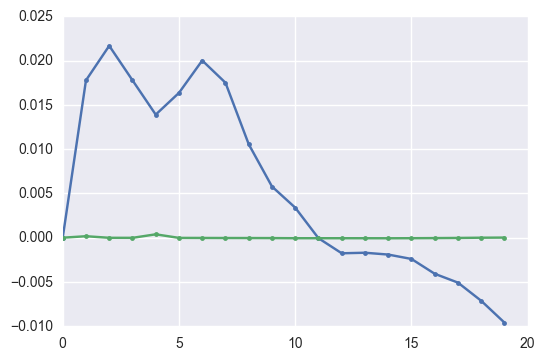

In [27]:
i_s = []
frsma = []
frewma = []
for i in range(20):
    i_s.append(i)
    fut_ret_sma = metrics.aggregated_predicted_future_return(
        prices=prices_test, prediction=Y_test_pred, agg_period=i, mode='sma').mean() *1e4
    frsma.append(fut_ret_sma)
    
    fut_ret_ewma = metrics.aggregated_predicted_future_return(
        prices=prices_test, prediction=Y_test_pred, agg_period=i, mode='ewm').mean() *1e4
    frewma.append(fut_ret_ewma)

plt.plot(i_s, frsma,'.-')
plt.plot(i_s, frewma,'.-')
    

??? why are perf charts below different to fut return charts from performance report.????

In [ ]:
def perf(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    cats = utils.prediction_to_category2(preds)
    # turn true/false into +1/-1
    signs = cats*2 -1 
    
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [ ]:
def perf2(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    # turn true/false into +1/-1
    signs = preds - 0.5
    
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [ ]:
def perf3(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    # turn true/false into +1/-1
    signs = (preds - 0.5)
    signs = np.tanh(signs/2)
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [ ]:
print perf(Y_test_pred, fut_return_test).sum()
print perf2(Y_test_pred, fut_return_test).sum()
print perf3(Y_test_pred, fut_return_test).sum()

In [ ]:
perf(Y_test_pred, fut_return_test).cumsum().plot(label='perf')
perf2(Y_test_pred, fut_return_test).cumsum().plot(label='perf2')
perf3(Y_test_pred, fut_return_test).cumsum().plot(label='perf3')
plt.legend()

-----------------------------------

## Control

In [ ]:
X_control, Y_control, prices_control, fut_return_control = datasets.prepare_dataset1(df=datasets.random_ohlc(100000),lookahead=1, window=60)

In [ ]:
X_test.describe()

In [ ]:
X_control.describe()

In [ ]:
Y_control_pred = model.predict(X_control.as_matrix(), batch_size=1024)
Y_control_pred_class = utils.prediction_to_category2(Y_control_pred)
metrics.performance_report("control",  prices_control,  lookahead, Y_control, Y_control_pred_class)

In [ ]:
(fut_return_control.ix[~Y_control_pred_class[:,0]]+1).mean() - fut_return_control.mean() - 1